In [68]:
import shutil
from torch.utils.data import Dataset

import os,csv
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [69]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 45*45
NUM_CLASSES = 45

# Other
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [70]:
df_train = pd.read_csv('sample_train.csv')
print('Class distribution Train', np.bincount(df_train['Class Label'].values))

Class distribution Train [ 117   46    8   24  103   98   49   14   12   56   10    2    3  185
  247   22 1383   22  171 1847   12  506  134  157  155   96    6   32
  114   35    3   27  160   77   75  146   45  810   19  743   21  141
  814   45   41]


mathsymbol/!_1008.jpg


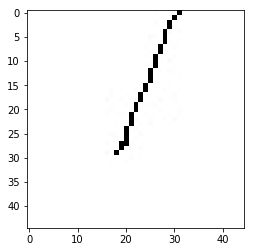

mathsymbol/!_102.jpg


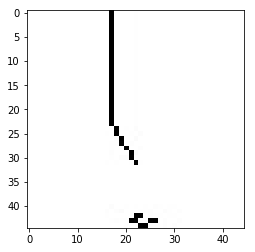

mathsymbol/!_279.jpg


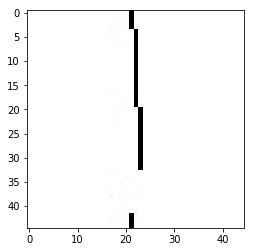

In [71]:
import glob
image_paths = sorted(glob.glob('mathsymbol/*.jpg'))
for i in (12, 25,500):
    im_path = image_paths[i]
    print(im_path)
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()

In [72]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['Filename'].values
        self.y = df['Class Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [73]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='train.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, #### CHANGE IF YOU LIKE
                          shuffle=True,
                          num_workers=4)
print(train_loader)

valid_dataset = QuickdrawDataset(csv_path='valid.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_dataset = QuickdrawDataset(csv_path='test.csv',
                                img_dir='mathsymbol/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [74]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

#  Model1: 3convolution+3fully connected layer+maxpooling

In [17]:
##########################
### MODEL
##########################

class ConvNet1(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet1, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        #45*45*1=>45*45*16
        self.conv1 =  nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2) #padding=[1(45-1)-45+5]/2=2
        #45*45*16=>15*15*16
        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=3,padding=1) #padding=[3(15-1)-45+5]/2=1
        #15*15*16=>15*15*64
        self.conv2 =  nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2)  #padding=[1(15-1)-15+5]/2=2
        #15*15*64=>5*5*64
        self.maxpool2= nn.MaxPool2d(kernel_size=5, stride=3,padding=1) #padding=[3(5-1)-16+5]/2=0.5
        #5*5*64=>5*5*256
        self.conv3 =  nn.Conv2d(64, 256, kernel_size=5, stride=1, padding=1) #padding=[1(5-1)-5+3]/2=1
        #5*5*256=>1*1*256
        self.maxpool3= nn.MaxPool2d(kernel_size=5, stride=5) #padding=[5(1-1)-5+5]/2=0
        
        
        # ... <add the remaining convolutional layers
        # and fully connected layers ...
        
        self.linear1 = nn.Linear(256, 2048) 
        self.linear2 = nn.Linear(2048, 2048) 
        self.linear3 = nn.Linear(2048, NUM_CLASSES)  
        

    def forward(self, x):
        #print(x.size())
        x = self.conv1(x)
        x = F.relu(x)
        x=self.maxpool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x=self.maxpool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x=self.maxpool3(x)
        
        
        x=x.view(x.size(0), -1)
        
        x = self.linear1(x)
        x = F.relu(x)
        x=self.linear2(x)
        x = F.relu(x)
        
       
        
        
        
        
        # ... IMPLEMENT FORWARD PASS ...
        logits = self.linear3(x)# ...
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model1 = ConvNet1(NUM_CLASSES)


optimizer = torch.optim.Adam(model1.parameters(), lr=LEARNING_RATE)  

In [18]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def train(model, train_loader, test_loader):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 150:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader, device=DEVICE)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost
    

Epoch: 001/010 | Batch 0000/0863 | Cost: 3.7943
Epoch: 001/010 | Batch 0150/0863 | Cost: 0.5811
Epoch: 001/010 | Batch 0300/0863 | Cost: 0.2170
Epoch: 001/010 | Batch 0450/0863 | Cost: 0.3260
Epoch: 001/010 | Batch 0600/0863 | Cost: 0.0163
Epoch: 001/010 | Batch 0750/0863 | Cost: 0.1653
Epoch: 001/010 | Train: 97.641%
Time elapsed: 9.97 min
Epoch: 002/010 | Batch 0000/0863 | Cost: 0.1231
Epoch: 002/010 | Batch 0150/0863 | Cost: 0.0715
Epoch: 002/010 | Batch 0300/0863 | Cost: 0.1850
Epoch: 002/010 | Batch 0450/0863 | Cost: 0.1273
Epoch: 002/010 | Batch 0600/0863 | Cost: 0.0207
Epoch: 002/010 | Batch 0750/0863 | Cost: 0.0895
Epoch: 002/010 | Train: 98.771%
Time elapsed: 20.23 min
Epoch: 003/010 | Batch 0000/0863 | Cost: 0.0339
Epoch: 003/010 | Batch 0150/0863 | Cost: 0.0508
Epoch: 003/010 | Batch 0300/0863 | Cost: 0.0393
Epoch: 003/010 | Batch 0450/0863 | Cost: 0.0166
Epoch: 003/010 | Batch 0600/0863 | Cost: 0.0904
Epoch: 003/010 | Batch 0750/0863 | Cost: 0.0202
Epoch: 003/010 | Train: 9

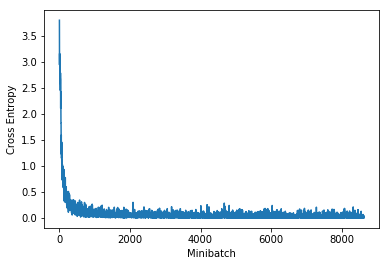

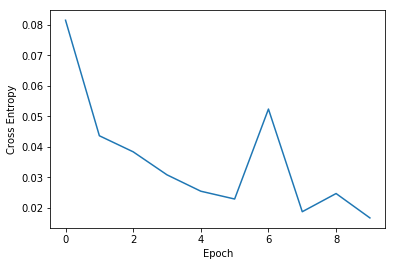

In [39]:
minibatch_cost, epoch_cost = train(model1, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

# train and validation model1

In [75]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def train(model, train_loader, test_loader):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 150:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader, device=DEVICE)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Validation Accuracy: %.3f%%' % (compute_accuracy(model, valid_loader, device=DEVICE)))

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost
    

Epoch: 001/010 | Batch 0000/0863 | Cost: 3.7943
Epoch: 001/010 | Batch 0150/0863 | Cost: 0.5811
Epoch: 001/010 | Batch 0300/0863 | Cost: 0.2170
Epoch: 001/010 | Batch 0450/0863 | Cost: 0.3260
Epoch: 001/010 | Batch 0600/0863 | Cost: 0.0163
Epoch: 001/010 | Batch 0750/0863 | Cost: 0.1653
Epoch: 001/010 | Train: 97.641%
Time elapsed: 8.86 min
Epoch: 002/010 | Batch 0000/0863 | Cost: 0.1231
Epoch: 002/010 | Batch 0150/0863 | Cost: 0.0715
Epoch: 002/010 | Batch 0300/0863 | Cost: 0.1850
Epoch: 002/010 | Batch 0450/0863 | Cost: 0.1273
Epoch: 002/010 | Batch 0600/0863 | Cost: 0.0207
Epoch: 002/010 | Batch 0750/0863 | Cost: 0.0895
Epoch: 002/010 | Train: 98.771%
Time elapsed: 18.36 min
Epoch: 003/010 | Batch 0000/0863 | Cost: 0.0339
Epoch: 003/010 | Batch 0150/0863 | Cost: 0.0508
Epoch: 003/010 | Batch 0300/0863 | Cost: 0.0393
Epoch: 003/010 | Batch 0450/0863 | Cost: 0.0166
Epoch: 003/010 | Batch 0600/0863 | Cost: 0.0904
Epoch: 003/010 | Batch 0750/0863 | Cost: 0.0202
Epoch: 003/010 | Train: 9

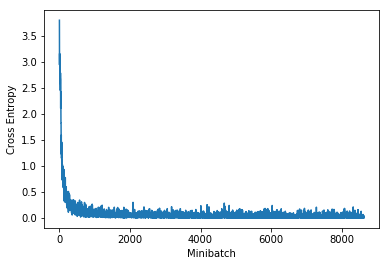

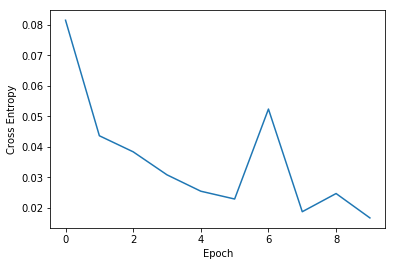

In [20]:
minibatch_cost, epoch_cost = train(model1, train_loader, valid_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [24]:
print('Test Accuracy: %.2f' % compute_accuracy(model1, test_loader,device=DEVICE))

Test Accuracy: 99.38


# Save model1

In [25]:
model1.to(torch.device('cpu'))
torch.save(model1.state_dict(),'./my_model1.pt')

# Reuse model1

In [26]:
import shutil
from torch.utils.data import Dataset

import os,csv
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [27]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 45*45
NUM_CLASSES = 45

# Other
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [28]:
##########################
### MODEL
##########################

class ConvNet1(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet1, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        #45*45*1=>45*45*16
        self.conv1 =  nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2) #padding=[1(45-1)-45+5]/2=2
        #45*45*16=>15*15*16
        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=3,padding=1) #padding=[3(15-1)-45+5]/2=1
        #15*15*16=>15*15*64
        self.conv2 =  nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2)  #padding=[1(15-1)-15+5]/2=2
        #15*15*64=>5*5*64
        self.maxpool2= nn.MaxPool2d(kernel_size=5, stride=3,padding=1) #padding=[3(5-1)-16+5]/2=0.5
        #5*5*64=>5*5*256
        self.conv3 =  nn.Conv2d(64, 256, kernel_size=5, stride=1, padding=1) #padding=[1(5-1)-5+3]/2=1
        #5*5*256=>1*1*256
        self.maxpool3= nn.MaxPool2d(kernel_size=5, stride=5) #padding=[5(1-1)-5+5]/2=0
        
        
        # ... <add the remaining convolutional layers
        # and fully connected layers ...
        
        self.linear1 = nn.Linear(256, 2048) 
        self.linear2 = nn.Linear(2048, 2048) 
        self.linear3 = nn.Linear(2048, NUM_CLASSES)  
        

    def forward(self, x):
        #print(x.size())
        x = self.conv1(x)
        x = F.relu(x)
        x=self.maxpool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x=self.maxpool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x=self.maxpool3(x)
        
        
        x=x.view(x.size(0), -1)
        
        x = self.linear1(x)
        x = F.relu(x)
        x=self.linear2(x)
        x = F.relu(x)
        
       
        
        
        
        
        # ... IMPLEMENT FORWARD PASS ...
        logits = self.linear3(x)# ...
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model1 = ConvNet1(NUM_CLASSES)


optimizer = torch.optim.Adam(model1.parameters(), lr=LEARNING_RATE)  

In [30]:
model1=ConvNet1(NUM_CLASSES)
model1.load_state_dict(torch.load('./my_model1.pt'))
model1=model1.to(DEVICE)
#optimizer=torch.optim.SGD(model.paramter(),lr-0.1)
#optimzier.load_state_dict(torch.load('./my_optimizer.pt'))
#scheduler=torch.optim.lr_schedule.ExponentialLR(optimzer,gamma=0.1,last_epoch=-1)
#scheduler.load_state_dict(torch.load('./my_scheduler.pt'))
#model.train()

# Model2: 3convolution+3fullyconnected+maxpooling+batchnorm

In [76]:
##########################
### MODEL +BatchNorm
##########################

class ConvNet12(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet12, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        #45*45*1=>45*45*16
        self.conv1 =  nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2) #padding=[1(45-1)-45+5]/2=2
        self.bn1=nn.BatchNorm2d(16)
        #45*45*16=>15*15*16
        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=3,padding=1) #padding=[3(15-1)-45+5]/2=1
        #15*15*16=>15*15*64
        self.conv2 =  nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2)  #padding=[1(15-1)-15+5]/2=2
        self.bn2=nn.BatchNorm2d(64)
        #15*15*64=>5*5*64
        self.maxpool2= nn.MaxPool2d(kernel_size=5, stride=3,padding=1) #padding=[3(5-1)-16+5]/2=0.5
        #5*5*64=>5*5*256
        self.conv3 =  nn.Conv2d(64, 256, kernel_size=5, stride=1, padding=1) #padding=[1(5-1)-5+3]/2=1
        self.bn3=nn.BatchNorm2d(256)
        #5*5*256=>1*1*256
        self.maxpool3= nn.MaxPool2d(kernel_size=5, stride=5) #padding=[5(1-1)-5+5]/2=0
        
        
        # ... <add the remaining convolutional layers
        # and fully connected layers ...
        
        self.linear1 = nn.Linear(256, 2048) 
        self.bn4 = nn.BatchNorm1d(2048)
        self.linear2 = nn.Linear(2048, 2048) 
        self.bn5 = nn.BatchNorm1d(2048)
        self.linear3 = nn.Linear(2048, NUM_CLASSES)  
        

    def forward(self, x):
        #print(x.size())
        x = self.conv1(x)
        x=self.bn1(x)
        x = F.relu(x)
        x=self.maxpool1(x)
        
        x = self.conv2(x)
        x=self.bn2(x)
        x = F.relu(x)
        x=self.maxpool2(x)
        
        x = self.conv3(x)
        x=self.bn3(x)
        x = F.relu(x)
        x=self.maxpool3(x)
        
        
        x=x.view(x.size(0), -1)
        
        x = self.linear1(x)
        x=self.bn4(x)
        x = F.relu(x)
        x=self.linear2(x)
        x=self.bn5(x)
        x = F.relu(x)
        
       
        
        
        
        
        # ... IMPLEMENT FORWARD PASS ...
        logits = self.linear3(x)# ...
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model12 = ConvNet12(NUM_CLASSES)


optimizer = torch.optim.Adam(model12.parameters(), lr=LEARNING_RATE)  

Epoch: 001/010 | Batch 0000/0863 | Cost: 3.8207
Epoch: 001/010 | Batch 0150/0863 | Cost: 0.1486
Epoch: 001/010 | Batch 0300/0863 | Cost: 0.0845
Epoch: 001/010 | Batch 0450/0863 | Cost: 0.0290
Epoch: 001/010 | Batch 0600/0863 | Cost: 0.0741
Epoch: 001/010 | Batch 0750/0863 | Cost: 0.0923
Epoch: 001/010 | Train: 98.704%
Time elapsed: 11.75 min
Epoch: 002/010 | Batch 0000/0863 | Cost: 0.0050
Epoch: 002/010 | Batch 0150/0863 | Cost: 0.0712
Epoch: 002/010 | Batch 0300/0863 | Cost: 0.0417
Epoch: 002/010 | Batch 0450/0863 | Cost: 0.0556
Epoch: 002/010 | Batch 0600/0863 | Cost: 0.0514
Epoch: 002/010 | Batch 0750/0863 | Cost: 0.0398
Epoch: 002/010 | Train: 98.967%
Time elapsed: 23.59 min
Epoch: 003/010 | Batch 0000/0863 | Cost: 0.0287
Epoch: 003/010 | Batch 0150/0863 | Cost: 0.0230
Epoch: 003/010 | Batch 0300/0863 | Cost: 0.0016
Epoch: 003/010 | Batch 0450/0863 | Cost: 0.0210
Epoch: 003/010 | Batch 0600/0863 | Cost: 0.0505
Epoch: 003/010 | Batch 0750/0863 | Cost: 0.1114
Epoch: 003/010 | Train: 

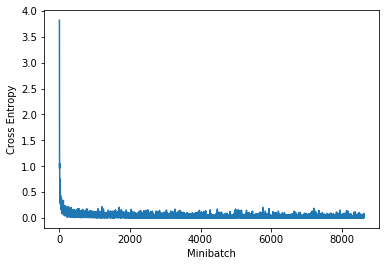

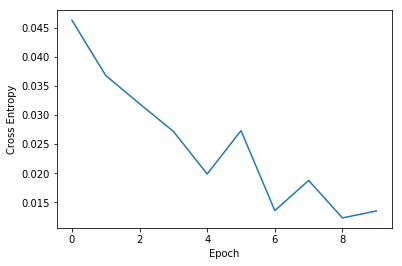

In [14]:
minibatch_cost, epoch_cost = train(model12, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

# train and validation model2

Epoch: 001/010 | Batch 0000/0863 | Cost: 3.8207
Epoch: 001/010 | Batch 0150/0863 | Cost: 0.1486
Epoch: 001/010 | Batch 0300/0863 | Cost: 0.0845
Epoch: 001/010 | Batch 0450/0863 | Cost: 0.0290
Epoch: 001/010 | Batch 0600/0863 | Cost: 0.0741
Epoch: 001/010 | Batch 0750/0863 | Cost: 0.0923
Epoch: 001/010 | Train: 98.704%
Time elapsed: 11.89 min
Epoch: 002/010 | Batch 0000/0863 | Cost: 0.0050
Epoch: 002/010 | Batch 0150/0863 | Cost: 0.0712
Epoch: 002/010 | Batch 0300/0863 | Cost: 0.0417
Epoch: 002/010 | Batch 0450/0863 | Cost: 0.0556
Epoch: 002/010 | Batch 0600/0863 | Cost: 0.0514
Epoch: 002/010 | Batch 0750/0863 | Cost: 0.0398
Epoch: 002/010 | Train: 98.967%
Time elapsed: 23.13 min
Epoch: 003/010 | Batch 0000/0863 | Cost: 0.0287
Epoch: 003/010 | Batch 0150/0863 | Cost: 0.0230
Epoch: 003/010 | Batch 0300/0863 | Cost: 0.0016
Epoch: 003/010 | Batch 0450/0863 | Cost: 0.0210
Epoch: 003/010 | Batch 0600/0863 | Cost: 0.0505
Epoch: 003/010 | Batch 0750/0863 | Cost: 0.1114
Epoch: 003/010 | Train: 

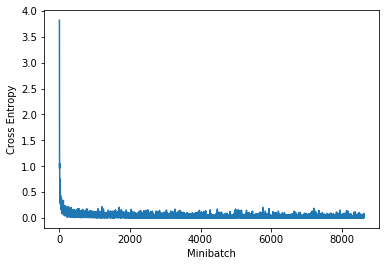

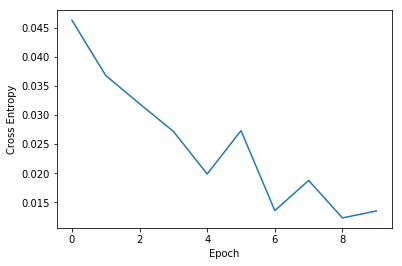

In [77]:
minibatch_cost, epoch_cost = train(model12, train_loader, valid_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [80]:
print('Test Accuracy: %.2f' % compute_accuracy(model1, test_loader,device=DEVICE))

Test Accuracy: 99.38


# Save model2 

In [81]:
model12.to(torch.device('cpu'))
torch.save(model12.state_dict(),'./my_model12.pt')

# Reuse Model2

In [82]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 45*45
NUM_CLASSES = 45

# Other
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [83]:
##########################
### MODEL +BatchNorm
##########################

class ConvNet12(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet12, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        #45*45*1=>45*45*16
        self.conv1 =  nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2) #padding=[1(45-1)-45+5]/2=2
        self.bn1=nn.BatchNorm2d(16)
        #45*45*16=>15*15*16
        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=3,padding=1) #padding=[3(15-1)-45+5]/2=1
        #15*15*16=>15*15*64
        self.conv2 =  nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2)  #padding=[1(15-1)-15+5]/2=2
        self.bn2=nn.BatchNorm2d(64)
        #15*15*64=>5*5*64
        self.maxpool2= nn.MaxPool2d(kernel_size=5, stride=3,padding=1) #padding=[3(5-1)-16+5]/2=0.5
        #5*5*64=>5*5*256
        self.conv3 =  nn.Conv2d(64, 256, kernel_size=5, stride=1, padding=1) #padding=[1(5-1)-5+3]/2=1
        self.bn3=nn.BatchNorm2d(256)
        #5*5*256=>1*1*256
        self.maxpool3= nn.MaxPool2d(kernel_size=5, stride=5) #padding=[5(1-1)-5+5]/2=0
        
        
        # ... <add the remaining convolutional layers
        # and fully connected layers ...
        
        self.linear1 = nn.Linear(256, 2048) 
        self.bn4 = nn.BatchNorm1d(2048)
        self.linear2 = nn.Linear(2048, 2048) 
        self.bn5 = nn.BatchNorm1d(2048)
        self.linear3 = nn.Linear(2048, NUM_CLASSES)  
        

    def forward(self, x):
        #print(x.size())
        x = self.conv1(x)
        x=self.bn1(x)
        x = F.relu(x)
        x=self.maxpool1(x)
        
        x = self.conv2(x)
        x=self.bn2(x)
        x = F.relu(x)
        x=self.maxpool2(x)
        
        x = self.conv3(x)
        x=self.bn3(x)
        x = F.relu(x)
        x=self.maxpool3(x)
        
        
        x=x.view(x.size(0), -1)
        
        x = self.linear1(x)
        x=self.bn4(x)
        x = F.relu(x)
        x=self.linear2(x)
        x=self.bn5(x)
        x = F.relu(x)
        
       
        
        
        
        
        # ... IMPLEMENT FORWARD PASS ...
        logits = self.linear3(x)# ...
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model12 = ConvNet12(NUM_CLASSES)


optimizer = torch.optim.Adam(model12.parameters(), lr=LEARNING_RATE)  

In [84]:
model12=ConvNet12(NUM_CLASSES)
model12.load_state_dict(torch.load('./my_model12.pt'))
model12=model12.to(DEVICE)
#optimizer=torch.optim.SGD(model.paramter(),lr-0.1)
#optimzier.load_state_dict(torch.load('./my_optimizer.pt'))
#scheduler=torch.optim.lr_schedule.ExponentialLR(optimzer,gamma=0.1,last_epoch=-1)
#scheduler.load_state_dict(torch.load('./my_scheduler.pt'))
#model.train()

# 3Convolution+3 fully connected layer without maxpooling+dropouts

In [11]:
##########################
### MODEL
##########################

class ConvNet2(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet2, self).__init__()
        self.drop02=nn.Dropout2d(0.2)
        self.drop05=nn.Dropout2d(0.5)
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        #45*45*1=>15*15*32
        self.conv1 =  nn.Conv2d(1, 32, kernel_size=5, stride=3,padding=1) #padding=[3(15-1)-45+5]/2=1
        self.bn1=nn.BatchNorm2d(32)
        
        #15*15*32=>3*3*128
        self.conv2 =  nn.Conv2d(32, 128, kernel_size=5, stride=5)  #padding=[5(3-1)-15+5]/2=0
        self.bn2=nn.BatchNorm2d(128)
        
        #3*3*128=>1*1*256
        self.conv3 =  nn.Conv2d(128, 256, kernel_size=5, stride=3) #padding=[3(1-1)-3+3]/2=0
        self.bn3=nn.BatchNorm2d(256)

        
        
        
        # ... <add the remaining convolutional layers
        # and fully connected layers ...
        
        self.linear1 = nn.Linear(256, 2048) 
        self.bn4 = nn.BatchNorm1d(2048)
        self.linear2 = nn.Linear(2048, 2048)
        self.bn5 = nn.BatchNorm1d(2048)
        self.linear3 = nn.Linear(2048, NUM_CLASSES)  
        

    def forward(self, x):
        
        x = self.conv1(x)
        x=self.bn1(x)
        x=self.drop02(x)
        x = F.relu(x)
       
        x = self.conv2(x)
        x=self.bn2(x)
        x=self.drop02(x)
        x = F.relu(x)
        
        
        x = self.conv3(x)
        x=self.bn3(x)
        x=self.drop02(x)
        x = F.relu(x)
        
        
        
        x=x.view(x.size(0), -1)
        
        x = self.linear1(x)
        x=self.bn4(x)
        x = F.relu(x)
        x=self.drop05(x)
        
        x=self.linear2(x)
        x=self.bn5(x)
        x = F.relu(x)
        x=self.drop05(x)
        
       
        
        
        
        
        # ... IMPLEMENT FORWARD PASS ...
        logits = self.linear3(x)# ...
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model2 = ConvNet2(NUM_CLASSES)


optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE)  

Epoch: 001/010 | Batch 0000/0863 | Cost: 3.9083
Epoch: 001/010 | Batch 0150/0863 | Cost: 0.4888
Epoch: 001/010 | Batch 0300/0863 | Cost: 0.2561
Epoch: 001/010 | Batch 0450/0863 | Cost: 0.1550
Epoch: 001/010 | Batch 0600/0863 | Cost: 0.1367
Epoch: 001/010 | Batch 0750/0863 | Cost: 0.0982
Epoch: 001/010 | Train: 98.214%
Time elapsed: 6.30 min
Epoch: 002/010 | Batch 0000/0863 | Cost: 0.2195
Epoch: 002/010 | Batch 0150/0863 | Cost: 0.1581
Epoch: 002/010 | Batch 0300/0863 | Cost: 0.1152
Epoch: 002/010 | Batch 0450/0863 | Cost: 0.1085
Epoch: 002/010 | Batch 0600/0863 | Cost: 0.0743
Epoch: 002/010 | Batch 0750/0863 | Cost: 0.1417
Epoch: 002/010 | Train: 99.024%
Time elapsed: 12.45 min
Epoch: 003/010 | Batch 0000/0863 | Cost: 0.0388
Epoch: 003/010 | Batch 0150/0863 | Cost: 0.1322
Epoch: 003/010 | Batch 0300/0863 | Cost: 0.0974
Epoch: 003/010 | Batch 0450/0863 | Cost: 0.0919
Epoch: 003/010 | Batch 0600/0863 | Cost: 0.0152
Epoch: 003/010 | Batch 0750/0863 | Cost: 0.0654
Epoch: 003/010 | Train: 9

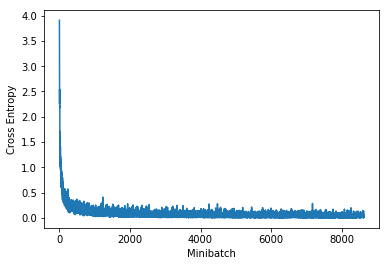

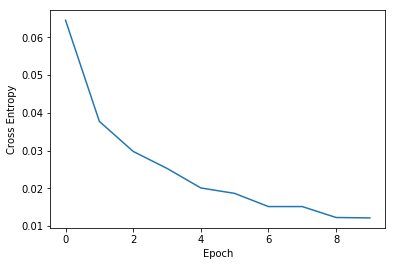

In [12]:
minibatch_cost, epoch_cost = train(model2, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

# predict

In [69]:
for root, dirs, files in os.walk('.'):
    for item in dirs:
        if (item[0]!='.'):
            try:
                os.remove(os.path.join(item,'.DS_Store'))
            except:
                pass

In [70]:
folders = os.listdir('extracted_images')
class_match = dict()
i = -1
for subfolder in folders:
    i += 1
    class_match[i] = subfolder

In [71]:
folders = os.listdir('extracted_images')
match_class = dict()
i = -1
for subfolder in folders:
    i += 1
    match_class[subfolder] = i
match_class

{'beta': 0,
 'pm': 1,
 'Delta': 2,
 'gamma': 3,
 'infty': 4,
 'rightarrow': 5,
 'div': 6,
 'gt': 7,
 'forward_slash': 8,
 'leq': 9,
 'mu': 10,
 'exists': 11,
 'in': 12,
 'times': 13,
 'sin': 14,
 '{': 15,
 '+': 16,
 '}': 17,
 'cos': 18,
 '-': 19,
 'sigma': 20,
 'sqrt': 21,
 'pi': 22,
 'int': 23,
 'sum': 24,
 'lim': 25,
 'lambda': 26,
 'neq': 27,
 'log': 28,
 'ldots': 29,
 'forall': 30,
 'lt': 31,
 'theta': 32,
 'ascii_124': 33,
 '!': 34,
 'alpha': 35,
 ']': 36,
 '(': 37,
 'prime': 38,
 '=': 39,
 'phi': 40,
 'tan': 41,
 ')': 42,
 '[': 43,
 'geq': 44}

True class: =


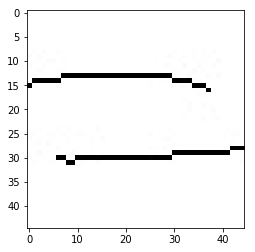

tensor([39])
Predict class:  =


,Class,Probability
0,=,1.000000e+00
1,lt,5.346154e-13
2,sum,3.791150e-13


In [72]:
application_index = [94392]#<=153,354

import glob
image_paths = sorted(glob.glob('mathsymbol/*.jpg'))
with open('application.csv', mode='w') as app:
    app_writer = csv.writer(app, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    app_writer.writerow(['Filename', 'Class Label'])
    for image in application_index:
        app_writer.writerow([image_paths[image].split('/')[1],match_class[image_paths[image].split('/')[1].split('_')[0]]])
    
for i in application_index:
    im_path = image_paths[i]
    print('True class:', im_path.split('/')[1].split('_')[0])
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()
    
application_dataset = QuickdrawDataset(csv_path='application.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)
application_loader = DataLoader(dataset=application_dataset,
                          batch_size=1, 
                          shuffle=True,
                          num_workers=4)

def predict(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        probas_read = pd.Series(probas.tolist()[0])
        #print(probas_read)
        class_label = pd.Series(list(range(NUM_CLASSES)))
        top3 = []
        top3 += [[class_match[list(class_label[probas_read == sorted(probas_read)[-1]])[0]], sorted(probas_read)[-1]]]
        top3 += [[class_match[list(class_label[probas_read == sorted(probas_read)[-2]])[0]], sorted(probas_read)[-2]]]
        top3 += [[class_match[list(class_label[probas_read == sorted(probas_read)[-3]])[0]], sorted(probas_read)[-3]]]
        top3 = pd.DataFrame(top3)
        _, predicted_labels = torch.max(probas, 1)
        print(predicted_labels)
        print('Predict class: ', class_match[int(predicted_labels)])
        top3.columns = ['Class', 'Probability']
        return top3

predict(model2, application_loader, DEVICE) 

# Resnet

In [31]:
GRAYSCALE = True

In [32]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=5, stride=1, padding=2,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=3, padding=1)
        self.layer1 = self._make_layer(block, 128, layers[0],stride=4)
        self.layer2 = self._make_layer(block, 256, layers[1], stride=4)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        #print(x.size())
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print(x.size())
        x = self.layer1(x)
        #print(x.size())
        x = self.layer2(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        #print(x.size())
        x = x.view(x.size(0), -1)
        
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [33]:
torch.manual_seed(RANDOM_SEED)

##########################
### COST AND OPTIMIZER
##########################

model = resnet34(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [34]:
NUM_EPOCHS=5


In [35]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='train.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=256, #### CHANGE IF YOU LIKE
                          shuffle=True,
                          num_workers=4)
print(train_loader)

valid_dataset = QuickdrawDataset(csv_path='valid.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=256,
                          shuffle=False,
                          num_workers=4)

test_dataset = QuickdrawDataset(csv_path='test.csv',
                                img_dir='mathsymbol/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=256,
                         shuffle=False,
                         num_workers=4)

In [36]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    

    
minibatch_cost, epoch_cost = [], []
all_train_acc, all_valid_acc = [], []

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        train_acc = compute_accuracy(model, train_loader)
        valid_acc = compute_accuracy(model, valid_loader)
        print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
              epoch+1, NUM_EPOCHS, train_acc, valid_acc))
        
        all_train_acc.append(train_acc)
        all_valid_acc.append(valid_acc)
        cost = compute_epoch_loss(model, train_loader)
        epoch_cost.append(cost)


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 0000/0432 | Cost: 3.9555
Epoch: 001/005 | Batch 0100/0432 | Cost: 0.1745
Epoch: 001/005 | Batch 0200/0432 | Cost: 0.0589
Epoch: 001/005 | Batch 0300/0432 | Cost: 0.0812
Epoch: 001/005 | Batch 0400/0432 | Cost: 0.0599
Epoch: 001/005 | Train: 98.418% | Valid: 98.085%
Time elapsed: 27.03 min
Epoch: 002/005 | Batch 0000/0432 | Cost: 0.0374
Epoch: 002/005 | Batch 0100/0432 | Cost: 0.0567
Epoch: 002/005 | Batch 0200/0432 | Cost: 0.0955
Epoch: 002/005 | Batch 0300/0432 | Cost: 0.0403
Epoch: 002/005 | Batch 0400/0432 | Cost: 0.0208
Epoch: 002/005 | Train: 98.670% | Valid: 98.402%
Time elapsed: 54.16 min
Epoch: 003/005 | Batch 0000/0432 | Cost: 0.0257
Epoch: 003/005 | Batch 0100/0432 | Cost: 0.0253
Epoch: 003/005 | Batch 0200/0432 | Cost: 0.0094
Epoch: 003/005 | Batch 0300/0432 | Cost: 0.0274
Epoch: 003/005 | Batch 0400/0432 | Cost: 0.0172
Epoch: 003/005 | Train: 99.116% | Valid: 99.038%
Time elapsed: 81.44 min
Epoch: 004/005 | Batch 0000/0432 | Cost: 0.0605
Epoch: 004/00

In [38]:
print('Test Accuracy: %.2f' % compute_accuracy(model,test_loader))

Test Accuracy: 98.94


In [39]:
model.to(torch.device('cpu'))
torch.save(model.state_dict(),'./my_model.pt')

# Reuse Resnet model

In [40]:
import shutil
from torch.utils.data import Dataset

import os,csv
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [41]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 216
NUM_EPOCHS = 5

# Architecture
NUM_FEATURES = 45*45
NUM_CLASSES = 45

# Other
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [42]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='train.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=256, #### CHANGE IF YOU LIKE
                          shuffle=True,
                          num_workers=4)
print(train_loader)

valid_dataset = QuickdrawDataset(csv_path='valid.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=256,
                          shuffle=False,
                          num_workers=4)

test_dataset = QuickdrawDataset(csv_path='test.csv',
                                img_dir='mathsymbol/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=256,
                         shuffle=False,
                         num_workers=4)

In [43]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=5, stride=1, padding=2,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=3, padding=1)
        self.layer1 = self._make_layer(block, 128, layers[0],stride=4)
        self.layer2 = self._make_layer(block, 256, layers[1], stride=4)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        #print(x.size())
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print(x.size())
        x = self.layer1(x)
        #print(x.size())
        x = self.layer2(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        #print(x.size())
        x = x.view(x.size(0), -1)
        
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [44]:
model=resnet34(NUM_CLASSES)
model.load_state_dict(torch.load('./my_model.pt'))
model=model.to(DEVICE)
#optimizer=torch.optim.SGD(model.paramter(),lr-0.1)
#optimzier.load_state_dict(torch.load('./my_optimizer.pt'))
#scheduler=torch.optim.lr_schedule.ExponentialLR(optimzer,gamma=0.1,last_epoch=-1)
#scheduler.load_state_dict(torch.load('./my_scheduler.pt'))
#model.train()

# Translate to latex language

In [15]:
latex_match={0:'\beta',1:'\pm',2:'\Delta',3:'\gamma',4:'\infty',5:'\to',6:'\div',7:'>',8:'\/',9:'\leq',10:'\mu',11:'\exists',12:'in',
            13:'\times',14:'sin',15:'\{',16:'+',17:'\}',18:'cos',19:'-',20:'\sigma',21:'\sqrt',22:'\pi',23:'\int',24:'\sum',
            25:'\lim',26:'\lambda',27:'\neq',28:'log',29:'\ldots',30:'\forall',31:'<',32:'\theta',33:'|',34:'!',35:'\alpha',
            36:']',37:'(',38:"''",39:'=',40:'\phi',41:'tan',42:')',43:'[',44:'\geq'}

In [74]:
def predict2(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        probas_read = pd.Series(probas.tolist()[0])
        class_label = pd.Series(list(range(NUM_CLASSES)))
        _, predicted_labels = torch.max(probas, 1)

        return predicted_labels.tolist()[0]

In [ ]:
def translate():
    x=int(input("Please input your application index:"))
    application_index = [x]#94392
    import glob
    image_paths = sorted(glob.glob('mathsymbol/*.jpg'))
    with open('application.csv', mode='w') as app:
        app_writer = csv.writer(app, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        app_writer.writerow(['Filename', 'Class Label'])
        for image in application_index:
            app_writer.writerow([image_paths[image].split('/')[1],match_class[image_paths[image].split('/')[1].split('_')[0]]])
    
    for i in application_index:
        im_path = image_paths[i]
        print('True class:', im_path.split('/')[1].split('_')[0])
        im = Image.open(im_path)
        plt.imshow(im)
        plt.show()
    application_dataset = QuickdrawDataset(csv_path='application.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)
    application_loader = DataLoader(dataset=application_dataset,
                          batch_size=1, 
                          shuffle=True,
                          num_workers=4)
    print('latex form:',latex_match[predict2(model2, application_loader, DEVICE)])
    

    return latex_match[predict2(model2, application_loader, DEVICE)]





In [ ]:
translate()

In [ ]:
print(torch.max.__doc__)